# High CO2 comparison
In this notebook, we'll compare the results presented in [Eisenhut M et al. 2017](https://www.cell.com/molecular-plant/pdf/S1674-2052(16)30219-2.pdf) for the transition from high to ambient CO2 with our transition from ambient oxygen to high oxygen. These conditions are comaprable because they both involve increasing photorespuratory flux by increasing the ratio of oxygen:CO2 available to rubisco. 

In [1]:
import pandas as pd
from os import listdir

The genes of interest are found in Table 1:

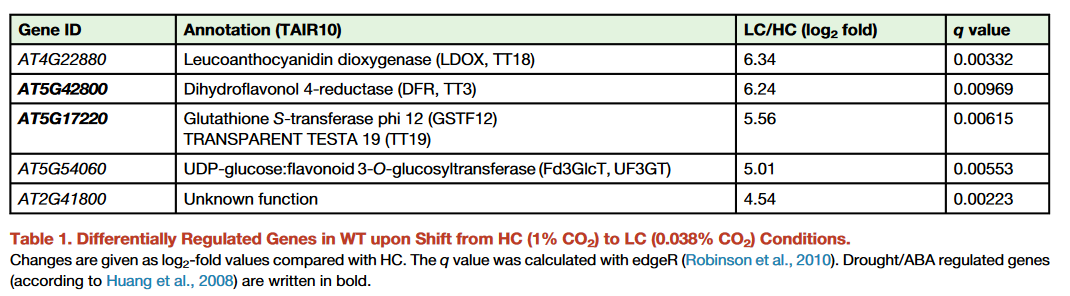

Do we find these differentially expressed in our 40% oxygen samples?

In [2]:
co2_genes = [
    'AT4G22880',
    'AT5G42800',
    'AT5G17220',
    'AT5G54060',
    'AT2G41800' 
]


We'll look both at the 7 hour and 1 hour timepoints separately as well as the filtered and unfiltered time conditions.

In [16]:
datapath = '../data/Araport11_outputs_ALL/deseq2_output/'
forty = {}
for f in listdir(datapath):
    name = '_'.join(f.split('_')[:4])
    if '40' in name:
        forty[name] = pd.read_csv(datapath+f)

In [17]:
forty['1h_vs_7h_40o2_filtered'] = pd.read_csv('../data/Araport11_outputs_ALL/deseq2_filtered/40_o2_7h_v_1h_filtered.csv')

In [18]:
for cond, df in forty.items():
    co2 = df[df['gene_id'].isin(co2_genes)]
    if len(co2) > 0:
        print(f'There are {len(co2)} high-to-ambient CO2 genes present at condition {cond}')

Looks like there's no overlap -- I'm not totally surprised, given how small the list of genes is from that paper (which in and of itself is surprising). What about the genes identified in the photorespiratory mutants? While we might not expect them to be differentially expressed in the same manner, perhaps they're important here as well.

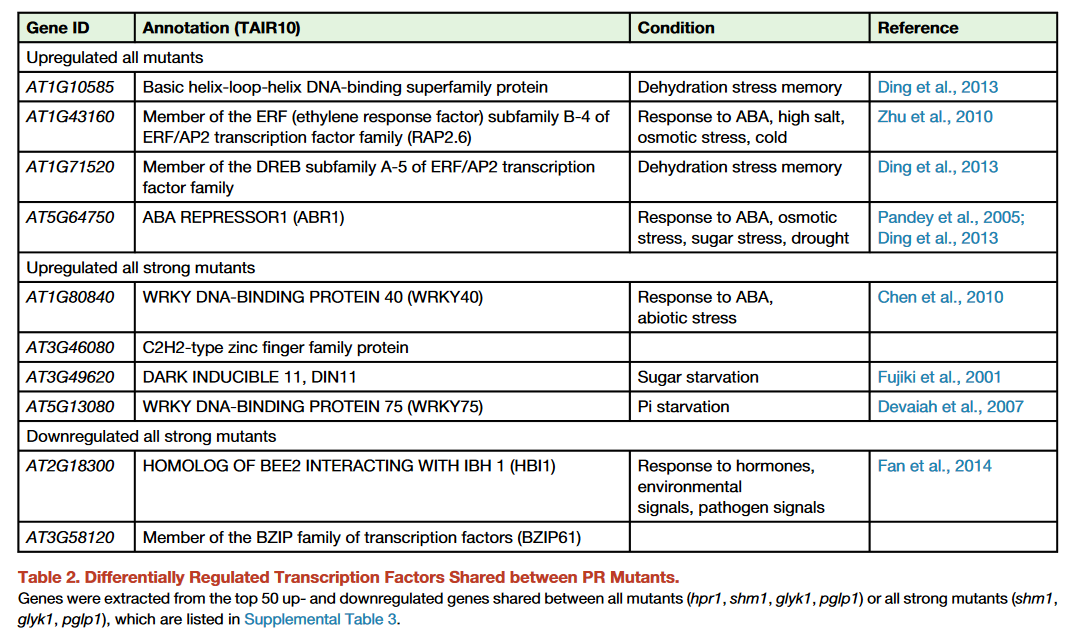

In [19]:
pr_mutant_genes = [
    'AT1G10585',
    'AT1G43160',
    'AT1G71520',
    'AT5G64750',
    'AT1G80840',
    'AT3G46080',
    'AT3G49620',
    'AT5G13080',
    'AT2G18300',
    'AT3G58120'
]

In [20]:
for cond, df in forty.items():
    pr = df[df['gene_id'].isin(pr_mutant_genes)]
    if len(pr) > 0:
        print(f'There are {len(pr)} high-to-ambient CO2 genes present at condition {cond}')

There are 1 high-to-ambient CO2 genes present at condition 1h_o2_40_21
There are 1 high-to-ambient CO2 genes present at condition 1h_vs_7h_40o2
There are 1 high-to-ambient CO2 genes present at condition 1h_vs_7h_40o2_filtered


In [21]:
pr

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
143,AT5G64750,61.447891,-2.962471,0.556364,-5.324696,0.00021,0.003003


This gene is described in the pape as ABA REPRESSOR1 and it is upregulated in all of their photorespiratory mutants. The fact that it is opposite here is not suprising, as we've done the opposite by placing WT plants in high oxygen. Does this gene behave oppositely in the 2% condition?

In [22]:
datapath = '../data/Araport11_outputs_ALL/deseq2_output/'
two = {}
for f in listdir(datapath):
    name = '_'.join(f.split('_')[:4])
    if ('_2_' in name) or '2o2' in name:
        two[name] = pd.read_csv(datapath+f)

In [23]:
two['1h_vs_7h_2o2_filtered'] = pd.read_csv('../data/Araport11_outputs_ALL/deseq2_filtered/2_o2_7h_v_1h_filtered.csv')

In [24]:
for cond, df in two.items():
    pr_2 = df[df['gene_id'].isin(pr_mutant_genes)]
    if len(pr_2) > 0:
        print(f'There are {len(pr_2)} high-to-ambient CO2 genes present at condition {cond}')

There are 3 high-to-ambient CO2 genes present at condition 1h_vs_7h_2o2
There are 2 high-to-ambient CO2 genes present at condition 7h_o2_2_21
There are 3 high-to-ambient CO2 genes present at condition 1h_vs_7h_2o2_filtered


In [25]:
pr_2

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
62,AT5G64750,69.283367,-5.530793,0.489162,-11.306669,9.998441e-21,5.408556e-19
115,AT3G58120,636.698670,-4.531807,0.249204,-18.185152,6.791844e-46,1.050100e-43
191,AT2G18300,228.345881,-3.488314,0.276023,-12.637784,9.853146e-20,5.154987e-18


Interestingly, it's also downregulated, but much more strongly. Additionally, it's not appearing in the oxygen comparisons, which suggests to me this may be a temporally-influenced gene and not one that's specifically involved in our process of interest.